# 2022.8.23
- Distance metric for image similarity (with digital watermark)
- (0,0) $\alpha$=50 > (0,0) $\alpha$=5 $\approx$ (80,80) $\alpha$ = 50
- Optimal algorithm for descrete problem

In [1]:
# google drive
# from google.colab import drive
# drive.mount('/content/drive')
# file address in google drive
file_root = './'

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pdb

In [3]:
def pltshow(img,gray=False):
    plt.figure(figsize=(5,5))
    plt.axis('off')
    if(gray):
        plt.imshow(img,cmap='gray')
    else:
        plt.imshow(img)

In [4]:
# load and show original image
img = cv2.imread('%sbag2.jpg'%file_root)
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

In [5]:
# load and show watermark image
wm = cv2.imread('%szhx2.jpg'%file_root,cv2.IMREAD_GRAYSCALE)
wm = np.where(wm<np.mean(wm),0,255)

In [6]:
# add border to image so that it can be divided perfectly with block_size
def addborder(img,block_size=4):
    diff_x = img.shape[0] % block_size
    diff_y = img.shape[1] % block_size
    if (diff_x==0 and diff_y==0):
        return img
    img = cv2.copyMakeBorder(img,
              0,(block_size-diff_x),
              0,(block_size-diff_y),
              cv2.BORDER_REPLICATE)
    return img

In [7]:
# tranform an image from original image to dct blocks
# param bk: a 2-dim numpy array
# param block_size: int
def dct_img(bk,block_size):
  img_dct_blocks_h = bk.shape[0] // block_size
  img_dct_blocks_w = bk.shape[1] // block_size
  img_dct_blocks = np.zeros(shape=(
      (img_dct_blocks_h,img_dct_blocks_w,block_size,block_size)
  ))
  h_data = np.vsplit(bk,img_dct_blocks_h)
  for h in range(img_dct_blocks_h):
    block_data = np.hsplit(h_data[h],img_dct_blocks_w)
    for w in range(img_dct_blocks_w):
        a_block = block_data[w]
        img_dct_blocks[h,w,...] = cv2.dct(a_block.astype(np.float64))
  return img_dct_blocks

In [8]:
# embed gray-scale watermrk into original RGB image
# param img: original image (3-dim RGB)
# param wm: watermark image (2-dim gray)
# param k1/k2: block-size 1-dim numpy array
# param alpha: embed strength
def embed_wm(img,wm,k1,k2,block_size=4,alpha=5,x=0,y=0):
  wm = np.where(wm<np.mean(wm),0,1)
  yuv_img = cv2.cvtColor(img,cv2.COLOR_RGB2YUV)
  Y,U,V = yuv_img[...,0],yuv_img[...,1],yuv_img[...,2]
  bk = U
  img_dct_blocks = dct_img(bk,block_size)
  dct_embed_result = img_dct_blocks.copy()
  if (wm.shape[0]+x>img_dct_blocks.shape[0] or wm.shape[1]+y>img_dct_blocks.shape[1]):
    print('Illegal location')
    return None
  for h in range(x,wm.shape[0]+x):
      for w in range(y,wm.shape[1]+y):
          k = k1 if wm[h-x,w-y] == 1 else k2
          for i in range(block_size):
              dct_embed_result[h,w,i,block_size-1] = \
              img_dct_blocks[h,w,i,block_size-1] + alpha * k[i]
  row = None
  idct_result = None
  for h in range(dct_embed_result.shape[0]):
      for w in range(dct_embed_result.shape[1]):
          block = cv2.idct(dct_embed_result[h,w,...])
          row = block if w == 0 else np.hstack((row,block))
      idct_result = row if h == 0 else np.vstack((idct_result,row))
  img_embed_result_yuv = np.stack((Y,idct_result,V),axis=2).astype(np.uint8)
  img_embed_result_bgr = cv2.cvtColor(img_embed_result_yuv,cv2.COLOR_YUV2BGR)
  img_embed_result = cv2.cvtColor(img_embed_result_bgr,cv2.COLOR_BGR2RGB)
  return img_embed_result

In [9]:
# ! pip install image-similarity-measures
import image_similarity_measures
from image_similarity_measures.quality_metrics import rmse, psnr, ssim, fsim,issm,sre,sam,uiq

In [10]:
from datetime import datetime
def metric_visual(img_list, wm, k1, k2, block_size=4, alpha_list=[5,50,100,200], metric_name='rmse', metric=rmse):
  img_num = len(img_list)
  alpha_num = len(alpha_list)
  plt.figure(figsize = (5*alpha_num,5*img_num))
  for i in range(img_num):
    for a in range(alpha_num):
      plt.subplot(img_num,alpha_num,alpha_num*i+a+1)
      img_wm = embed_wm(img_list[i],wm,k1,k2,block_size,alpha_list[a],x=0,y=0)
      plt.imshow(img_wm)
      plt.title('alpha={}\n{}={}'.format(alpha_list[a],metric_name,metric(img_wm,img_list[i])))
      plt.axis('off')
  plt.savefig('metric_visual_%s.jpg'%(datetime.now()))
  plt.show()

In [11]:
def mean2(x):
    y = np.sum(x) / np.size(x);
    return y
# correlation estimation
def corr2(a, b):
    a = a - mean2(a)
    b = b - mean2(b)
    r = (a * b).sum() / (np.sqrt((a * a).sum() * (b * b).sum())+1e-9)
    return r

In [12]:
# extract watermark from RGB wmed image
# param img: wmed RGB image
# param k1/k2: block-size 1-dim numpy array
# param wm_shape: 1-dim array [height,width] of watermark
# param block_size: int
def recover_wm(img,k1,k2,wm_shape,block_size=4,x=0,y=0):
  recover_wm = np.zeros(shape=wm.shape)
  yuv_img = cv2.cvtColor(img,cv2.COLOR_RGB2YUV)
  Y,U,V = yuv_img[...,0],yuv_img[...,1],yuv_img[...,2]
  bk = U
  wmed_dct_result = dct_img(bk,block_size)
  p = np.zeros(block_size)
  for h in range(x,wm_shape[0]+x):
      for w in range(y,wm_shape[1]+y):
          for k in range(block_size):
              p[k] = wmed_dct_result[h,w,k,block_size-1]
          if corr2(p,k1) > corr2(p,k2):
              recover_wm[h-x,w-y] = corr2(p,k1)
          else:
              recover_wm[h-x,w-y] = 0
  return recover_wm

In [13]:
def changebkcolor(img,low=np.array([5, 0, 0]),upper=np.array([255, 255, 220]),color=(255, 255, 0)):
    img_bk = img.copy()
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    mask = cv2.inRange(hsv, low, upper)
    rows,cols = mask.shape
    for i in range(rows):
        for j in range(cols):
            if mask[i, j] == 0:  # 255 means white
                img_bk[i, j] = color
    return img_bk

In [14]:
k1 = np.random.randn(4)
k2 = np.random.randn(4)

In [15]:
def show_origin_and_wmed(img,wm,block_size=4,k1 = np.random.randn(4),k2 = np.random.randn(4),alpha=5,x=0,y=0):
    img = addborder(img)
    wmed_img = embed_wm(img,wm,block_size,k1,k2,alpha,x,y)
    wm_extract = recover_wm(wmed_img,k1,k2,wm.shape,block_size,x,y)
    plt.figure(figsize=(20,10))
    plt.subplot(1,4,1)
    plt.imshow(img)
    plt.title('Original image')
    plt.axis('off')
    plt.subplot(1,4,2)
    plt.imshow(wmed_img)
    plt.title('With DCT watermark')
    plt.axis('off')
    plt.subplot(1,4,3)
    plt.imshow(wmed_img-img)
    plt.title('Difference')
    plt.axis('off')
    plt.subplot(1,4,4)
    plt.imshow(wm_extract,cmap='gray')
    plt.title('Extracted watermark')
    plt.axis('off')
    plt.show()

In [16]:
img_5_0_0 = embed_wm(img,wm,k1,k2)

img_50_0_0 = embed_wm(img,wm,k1,k2,alpha=50)

img_100_0_0 = embed_wm(img,wm,k1,k2,alpha=100)

img_200_0_0 = embed_wm(img,wm,k1,k2,alpha=200)

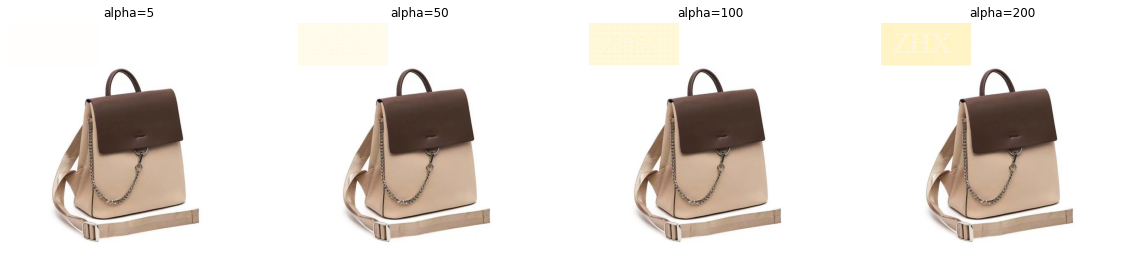

In [17]:
plt.figure(figsize=(20,20))
plt.subplot(1,4,1)
plt.imshow(img_5_0_0)
plt.title('alpha=5')
plt.axis('off')
plt.subplot(1,4,2)
plt.imshow(img_50_0_0)
plt.title('alpha=50')
plt.axis('off')
plt.subplot(1,4,3)
plt.imshow(img_100_0_0)
plt.title('alpha=100')
plt.axis('off')
plt.subplot(1,4,4)
plt.imshow(img_200_0_0)
plt.title('alpha=200')
plt.axis('off')
plt.show()

In [18]:
img_5_80_80 = embed_wm(img,wm,k1,k2,x=80,y=80)

img_50_80_80 = embed_wm(img,wm,k1,k2,alpha=50,x=80,y=80)

img_100_80_80 = embed_wm(img,wm,k1,k2,alpha=100,x=80,y=80)

img_200_80_80 = embed_wm(img,wm,k1,k2,alpha=200,x=80,y=80)

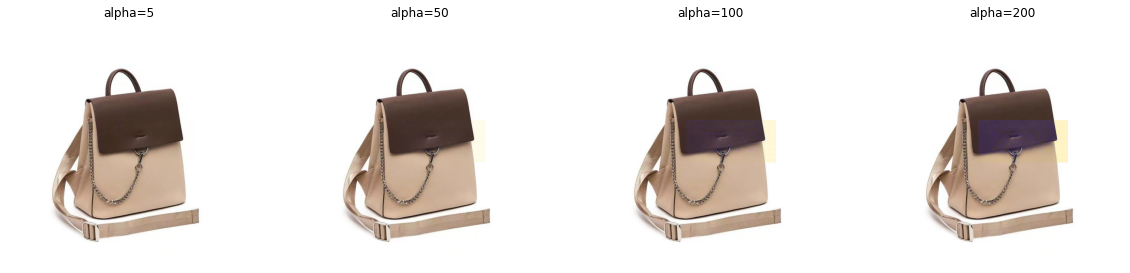

In [19]:
plt.figure(figsize=(20,20))
plt.subplot(1,4,1)
plt.imshow(img_5_80_80)
plt.title('alpha=5')
plt.axis('off')
plt.subplot(1,4,2)
plt.imshow(img_50_80_80)
plt.title('alpha=50')
plt.axis('off')
plt.subplot(1,4,3)
plt.imshow(img_100_80_80)
plt.title('alpha=100')
plt.axis('off')
plt.subplot(1,4,4)
plt.imshow(img_200_80_80)
plt.title('alpha=200')
plt.axis('off')
plt.show()

In [20]:
k1 = np.random.randn(4)
k2 = np.random.randn(4)

In [15]:
img_blue = changebkcolor(img,color=(0, 0, 255))
img_yellow = changebkcolor(img,color=(255, 255, 0))
img_ecru = changebkcolor(img,color=(203, 195, 160))

In [16]:
img_list = [img,img_blue,img_yellow,img_ecru]

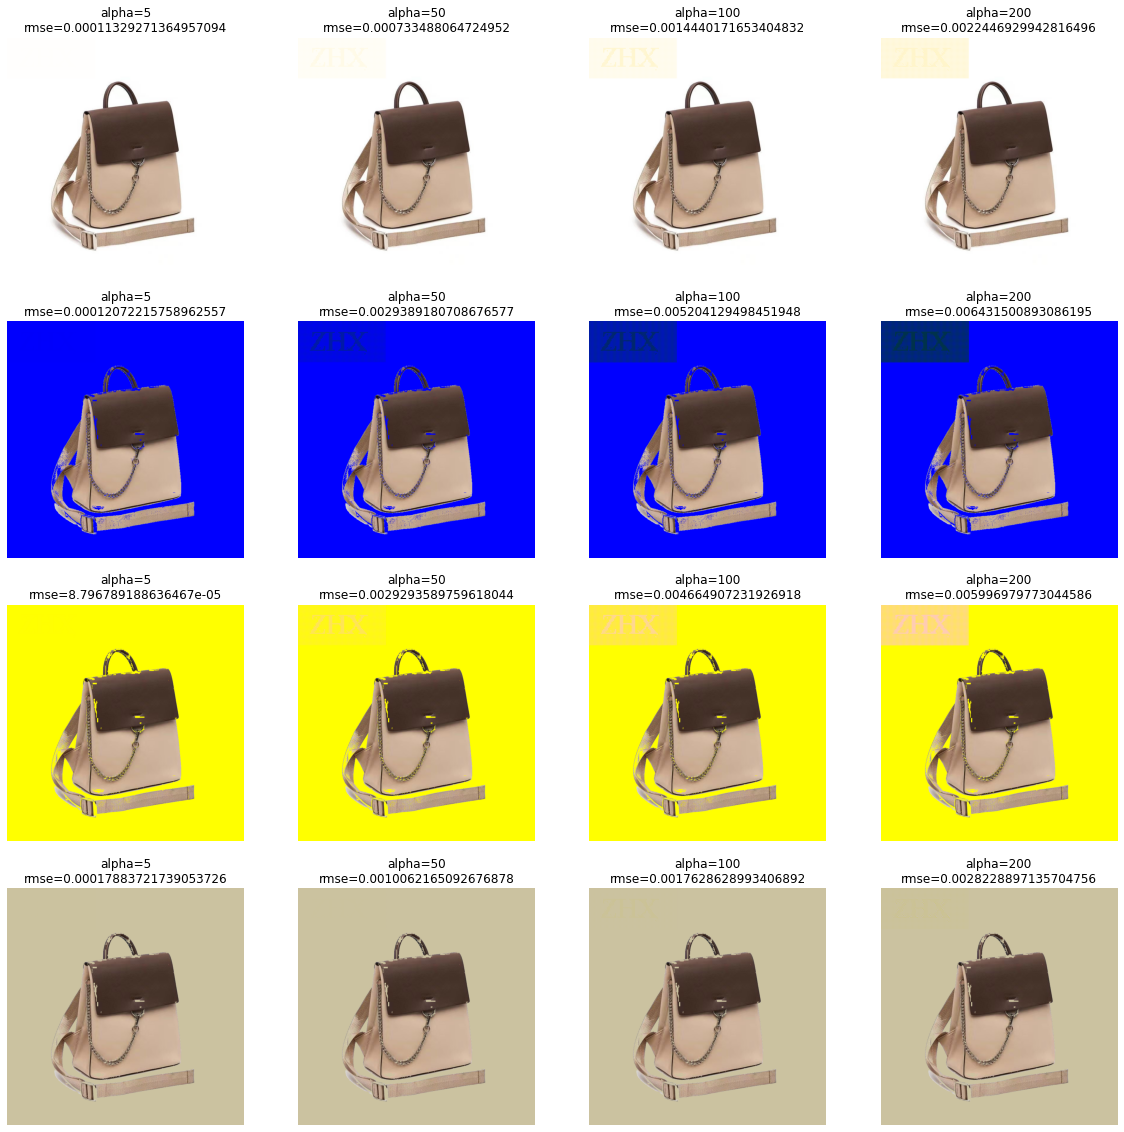

In [22]:
metric_visual(img_list, wm, k1, k2)

In [17]:
wm = cv2.imread('%szhx2.jpg'%file_root,cv2.IMREAD_GRAYSCALE)
wm = np.where(wm<np.mean(wm),0,255).astype('uint8')
wm_large = cv2.resize(wm,dsize=(200,100),fx=1,fy=1,interpolation=cv2.INTER_LINEAR)

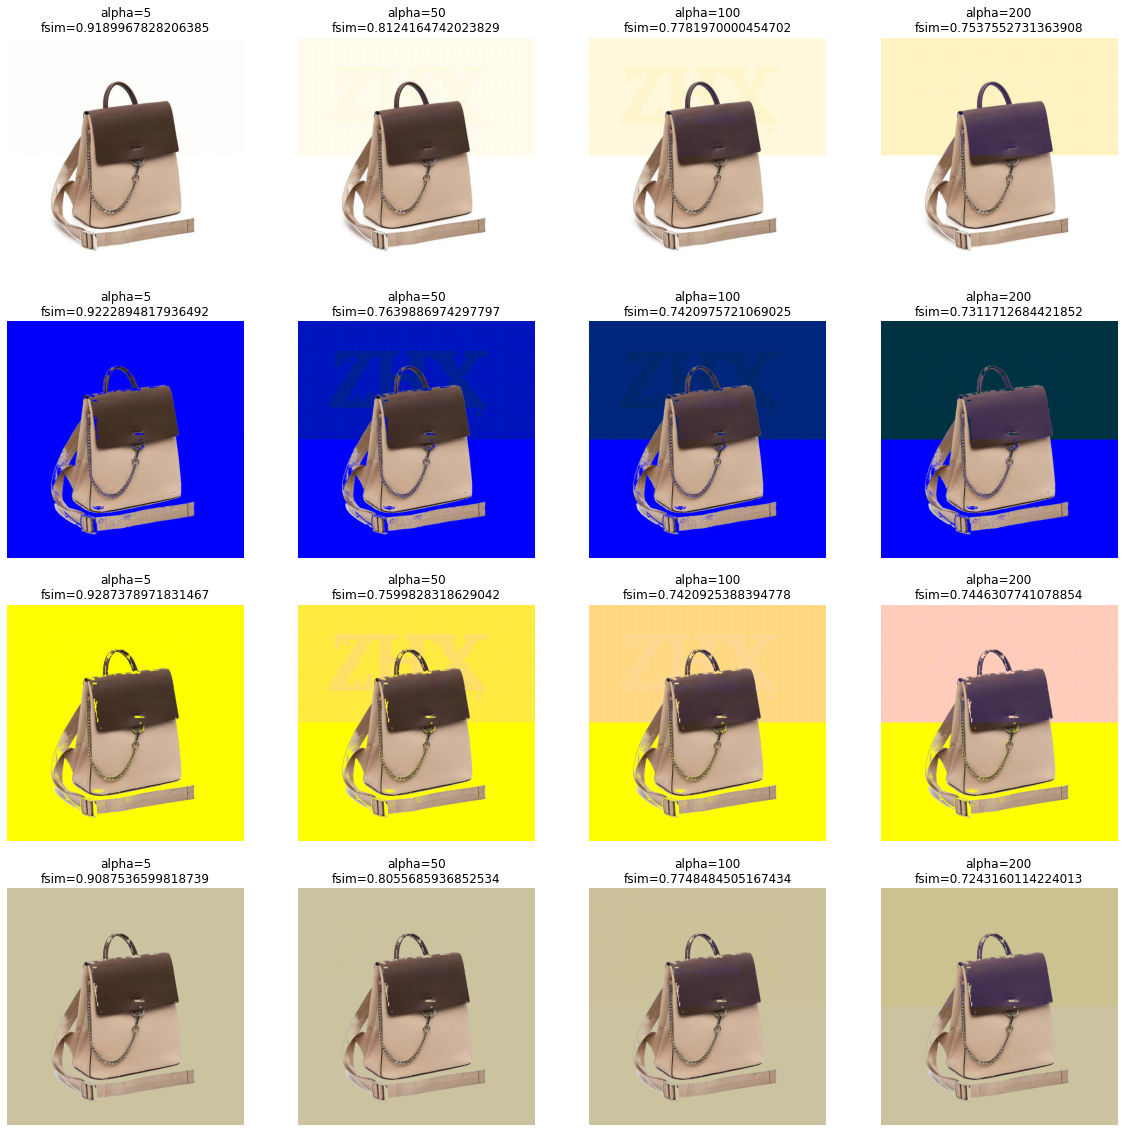

In [18]:
metric_visual(img_list, wm_large, k1, k2, metric_name='fsim', metric=fsim)